In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')

- Definimos una función para analizar la calidad de la data.

In [ ]:
def data_quality_analysis(df):
    result_df = pd.DataFrame(columns=['Columna', 'Tipo de dato', 'Valores únicos', 'Valores faltantes'])

    columns = df.columns
    data_types = df.dtypes.to_list()
    unique_values = [df[column].nunique() for column in columns]
    missing_values = [df[column].isnull().sum() for column in columns]

    result_df['Columna'] = columns
    result_df['Tipo de dato'] = data_types
    result_df['Valores únicos'] = unique_values
    result_df['Valores faltantes'] = missing_values

    return result_df.set_index('Columna')

- Leemos y analizamos los datos

In [ ]:
data = pd.read_excel('Retail_Invoices.xlsx')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate']).dt.date
data.InvoiceDate.min(), data.InvoiceDate.max()

(datetime.date(2010, 12, 1), datetime.date(2011, 12, 9))

In [ ]:
calidad = data_quality_analysis(data)
print(calidad)

            Tipo de dato  Valores únicos  Valores faltantes     tipo
Columna                                                             
InvoiceNo            NaN           22190                  0   object
InvoiceDate          NaN             305                  0   object
CustomerID           NaN            4372                  0    int64
Quantity             NaN            1594                  0    int64
price_total          NaN           16534                  0  float64
StockCode            NaN             199                  0    int64


1. No se observan nulos en un inicio.
2. Se observa que tanto Quantity y price_total tienen valores negativos, que deberíasn ser borrados, porque no se puede comprar un número negativo de elementos.
3. Se observan 4 valores con price_total igual a 0.
4. Se observa que no hay InvoiceNo repetidos, ya que la frecuencia máxima es 1.
5. Hay datos entre Diciembre del 2010 y Diciembre del 2011.

In [ ]:
mask = (data.Quantity>0) & (data.price_total>0)
data = data.loc[mask]
data.shape

(18532, 6)

In [ ]:
calidad = data_quality_analysis(data)
calidad

,Tipo de dato,Valores únicos,Valores faltantes,tipo
Columna,,,,
InvoiceNo,NaN,18532,0,object
InvoiceDate,NaN,305,0,object
CustomerID,NaN,4338,0,int64
Quantity,NaN,1394,0,int64
price_total,NaN,14927,0,float64
StockCode,NaN,199,0,int64


1. Existen valores muy alejados en Quantity y StockCode. Se observa que hay cantidades de 80.995, cierto el limite superior de outliers 617.
2. Hay que ver la frecuencia de los valores mayores a 617 y cortar lo necesario

- Análisis Exploratorio de los datos

In [ ]:
cols = ['CustomerID', 'Quantity', 'price_total', 'StockCode']

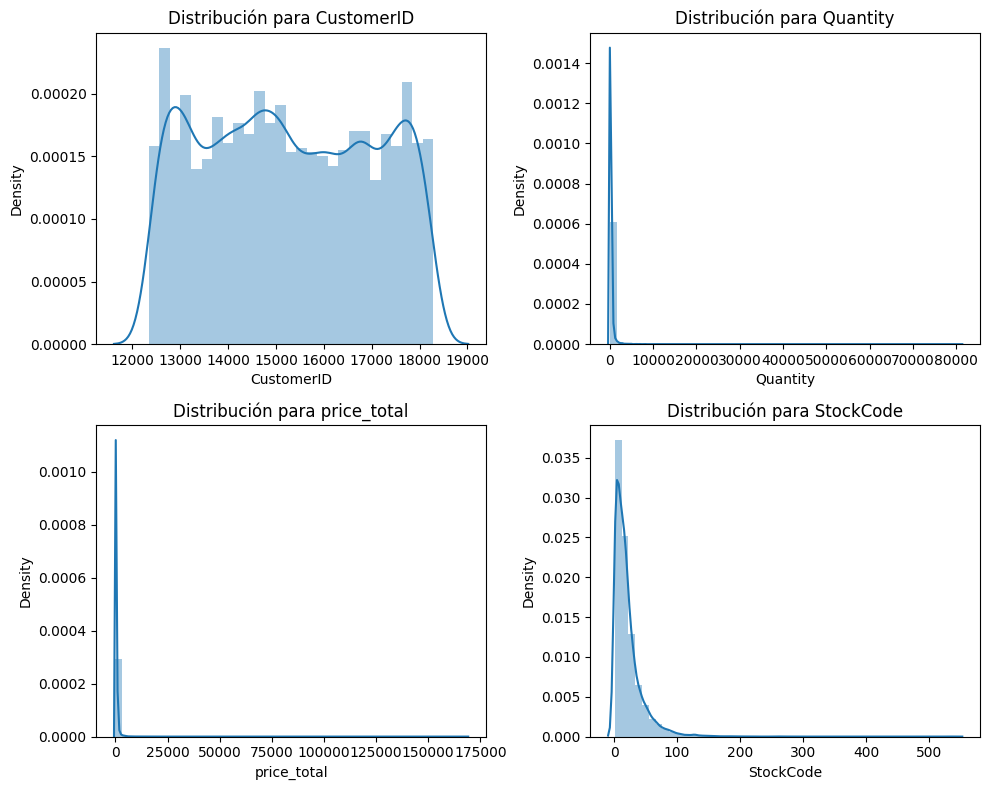

In [ ]:
plt.figure(figsize=(10, 8))
for n, i in enumerate(cols):
    plt.subplot(2, 2, n + 1)
    if calidad.loc[i, 'tipo']=='object':
        sns.countplot(y= data[i], order = data[i].value_counts().index)
        plt.title('Frecuencias para {}'.format(i))
        plt.tight_layout()
    else:
        sns.distplot(data[i])
        plt.title('Distribución para {}'.format(i))
        plt.tight_layout()

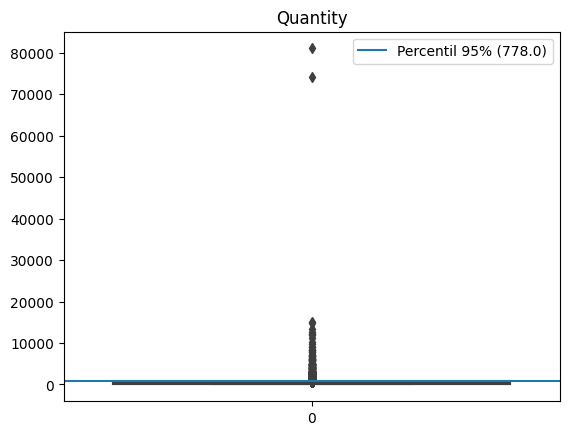

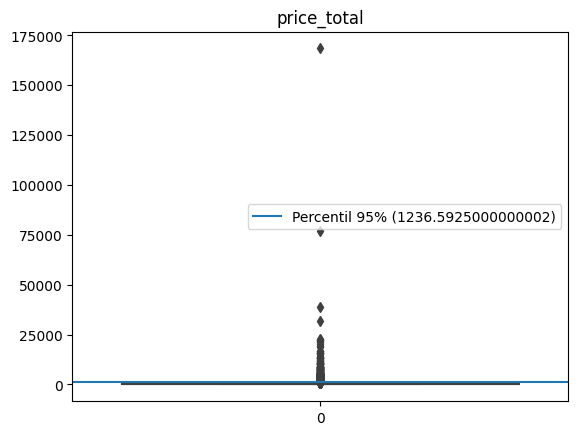

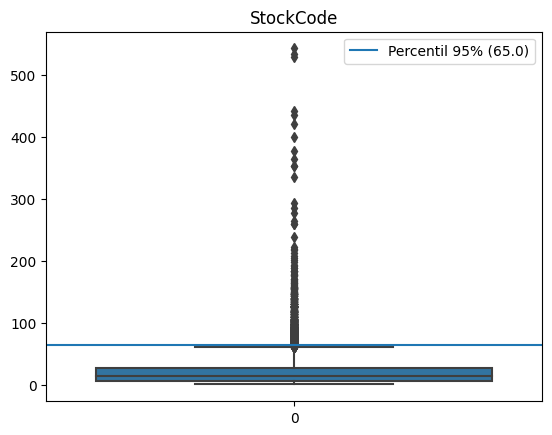

In [ ]:
for i in ['Quantity', 'price_total', 'StockCode']:
    sns.boxplot(data[i])
    quant_95 = data[i].quantile([0.95]).values[0]
    plt.axhline(quant_95, label=f'Percentil 95% ({quant_95})')
    plt.title(i)
    plt.legend()
    plt.xlabel('')
    plt.show()

In [ ]:
mask = (data.Quantity<data['Quantity'].quantile([0.95]).values[0]) & (data.price_total<data['price_total'].quantile([0.95]).values[0])
data_ = data.loc[mask]
data_['InvoiceDate'] = pd.to_datetime(data_['InvoiceDate'])
data_.shape

(17337, 6)

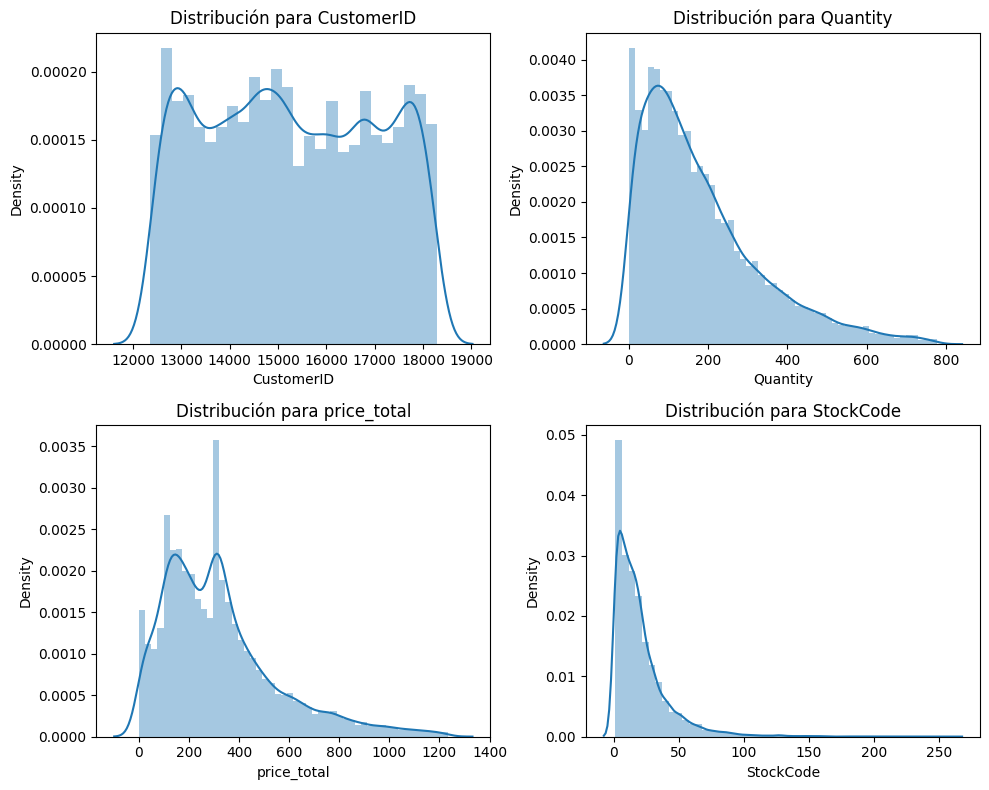

In [ ]:
plt.figure(figsize=(10, 8))
for n, i in enumerate(cols):
    plt.subplot(2, 2, n + 1)
    if calidad.loc[i, 'tipo']=='object':
        sns.countplot(y= data_[i], order = data_[i].value_counts().index)
        plt.title('Frecuencias para {}'.format(i))
        plt.tight_layout()
    else:
        sns.distplot(data_[i])
        plt.title('Distribución para {}'.format(i))
        plt.tight_layout()

<Axes: >

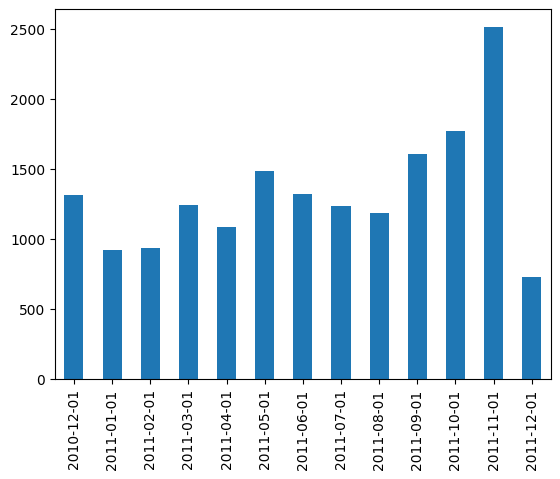

In [ ]:
data_['ano_mes'] = [i.replace(day=1) for i in pd.to_datetime(data_['InvoiceDate'])]

data_.ano_mes.dt.date.value_counts().sort_index().plot(kind='bar')

Con esta información uno observa que Diciembre 2011 no esta completo, además que vimos que solo hay data hasta el 9 de diciemrbe del año 2011. Se procura hacer el análisis con una ventana de 12 meses, entre Diciembre 2010 y Noviembre 2011.

Se ve una tendencia al aumento de boletas en el año 2011, con un pico en los últimos 3 meses.

<Axes: >

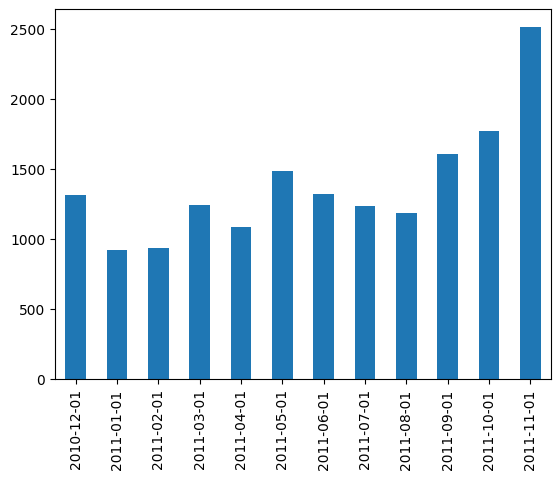

In [ ]:
data_ = data_.loc[data_.InvoiceDate<'2011-12-01']
data_.ano_mes.dt.date.value_counts().sort_index().plot(kind='bar')

Text(0.5, 1.0, 'Correlaciones')

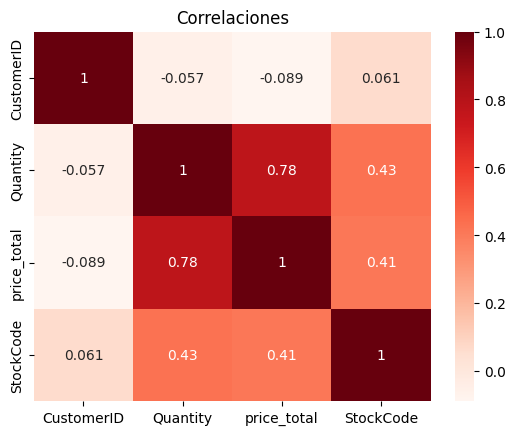

In [ ]:
sns.heatmap(data_.corr(), cmap='Reds', annot=True)
plt.title('Correlaciones')

Se observa lo siguiente.
1. Claramente hay una correlacion fuerte entre numero de boleta y la fecha, ya que esta va creciendo en base hay más boletas y eso se correlaciona con las fechas.
2. La cantidad de productos se correlaciona fuertemente con el precio total de la boleta, pero no tanto asi con la cantidad de productos distintos.

- Variables de Segmentación

In [ ]:
data_.head(2)

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode,ano_mes
0,536365,2010-12-01,17850,40,139.12,7,2010-12-01
1,536366,2010-12-01,17850,12,22.20,2,2010-12-01


In [ ]:
data_seg = data_.groupby('CustomerID').agg(
            ult_compra = ('InvoiceDate', 'max'),
            frecuencia = ('InvoiceNo', 'count'),
            cantidad_promedio = ('Quantity', 'mean'),
            cantidad_total = ('Quantity', 'sum'),
            monto_promedio = ('price_total', 'mean'),
            monto_total = ('price_total', 'sum'),
            articulos_distintos_promedio = ('StockCode', 'mean'),
            distintos_meses = ('ano_mes', 'nunique')
        )
data_seg

,ult_compra,frecuencia,cantidad_promedio,cantidad_total,monto_promedio,monto_total,articulos_distintos_promedio,distintos_meses
CustomerID,,,,,,,,
12347,2011-08-02,5,318.000000,1590,558.172,2790.86,24.800000,5
12348,2011-09-25,3,362.333333,1087,301.480,904.44,4.666667,3
12350,2011-02-02,1,197.000000,197,334.400,334.40,17.000000,1
12352,2011-11-03,8,67.000000,536,313.255,2506.04,10.625000,4
12353,2011-05-19,1,20.000000,20,89.000,89.00,4.000000,1
...,...,...,...,...,...,...,...,...
18280,2011-03-07,1,45.000000,45,180.600,180.60,10.000000,1
18281,2011-06-12,1,54.000000,54,80.820,80.82,7.000000,1
18282,2011-08-05,1,75.000000,75,100.210,100.21,7.000000,1


Se toma el supuesto de un análisis a principio del Diciembre 2011, por lo que la recencia se marca desde ese día.

In [ ]:
data_seg['recencia_dias'] = (pd.to_datetime('2011-12-01') - data_seg['ult_compra']).dt.days

- Análisis Exploratorio y Transformaciones

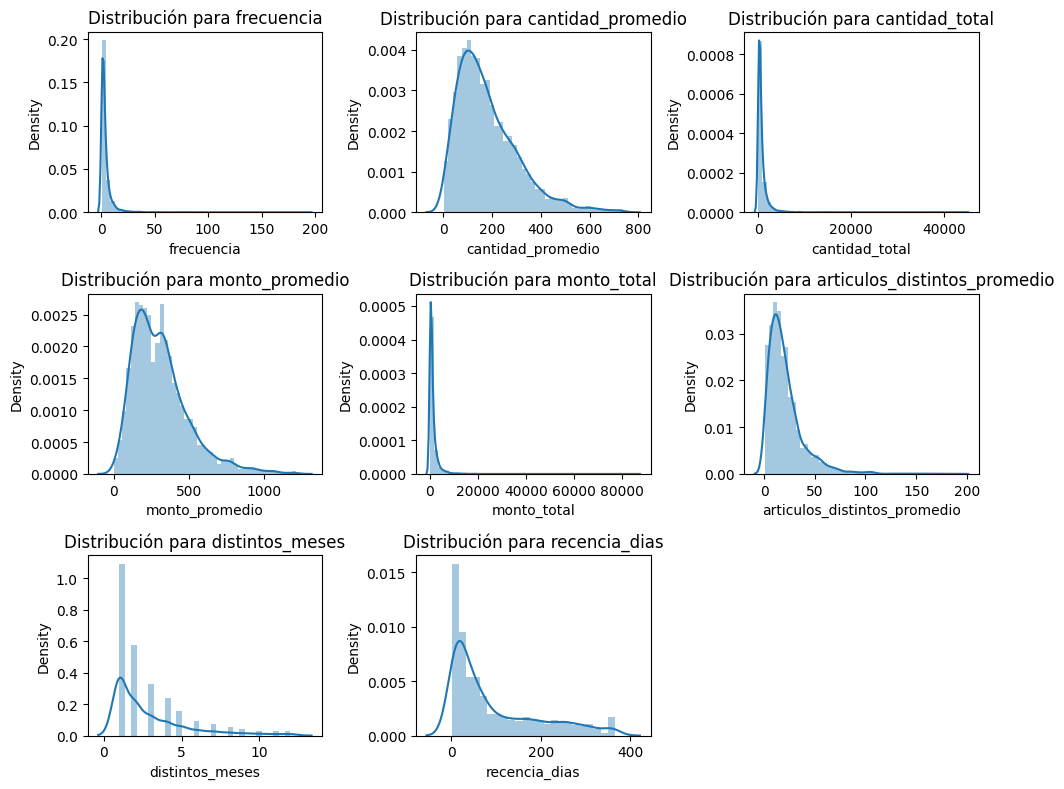

In [ ]:
plt.figure(figsize=(10, 8))
for n, i in enumerate(data_seg.columns[1:]):
    plt.subplot(3, 3, n + 1)
    sns.distplot(data_seg[i])
    plt.title('Distribución para {}'.format(i))
    plt.tight_layout()

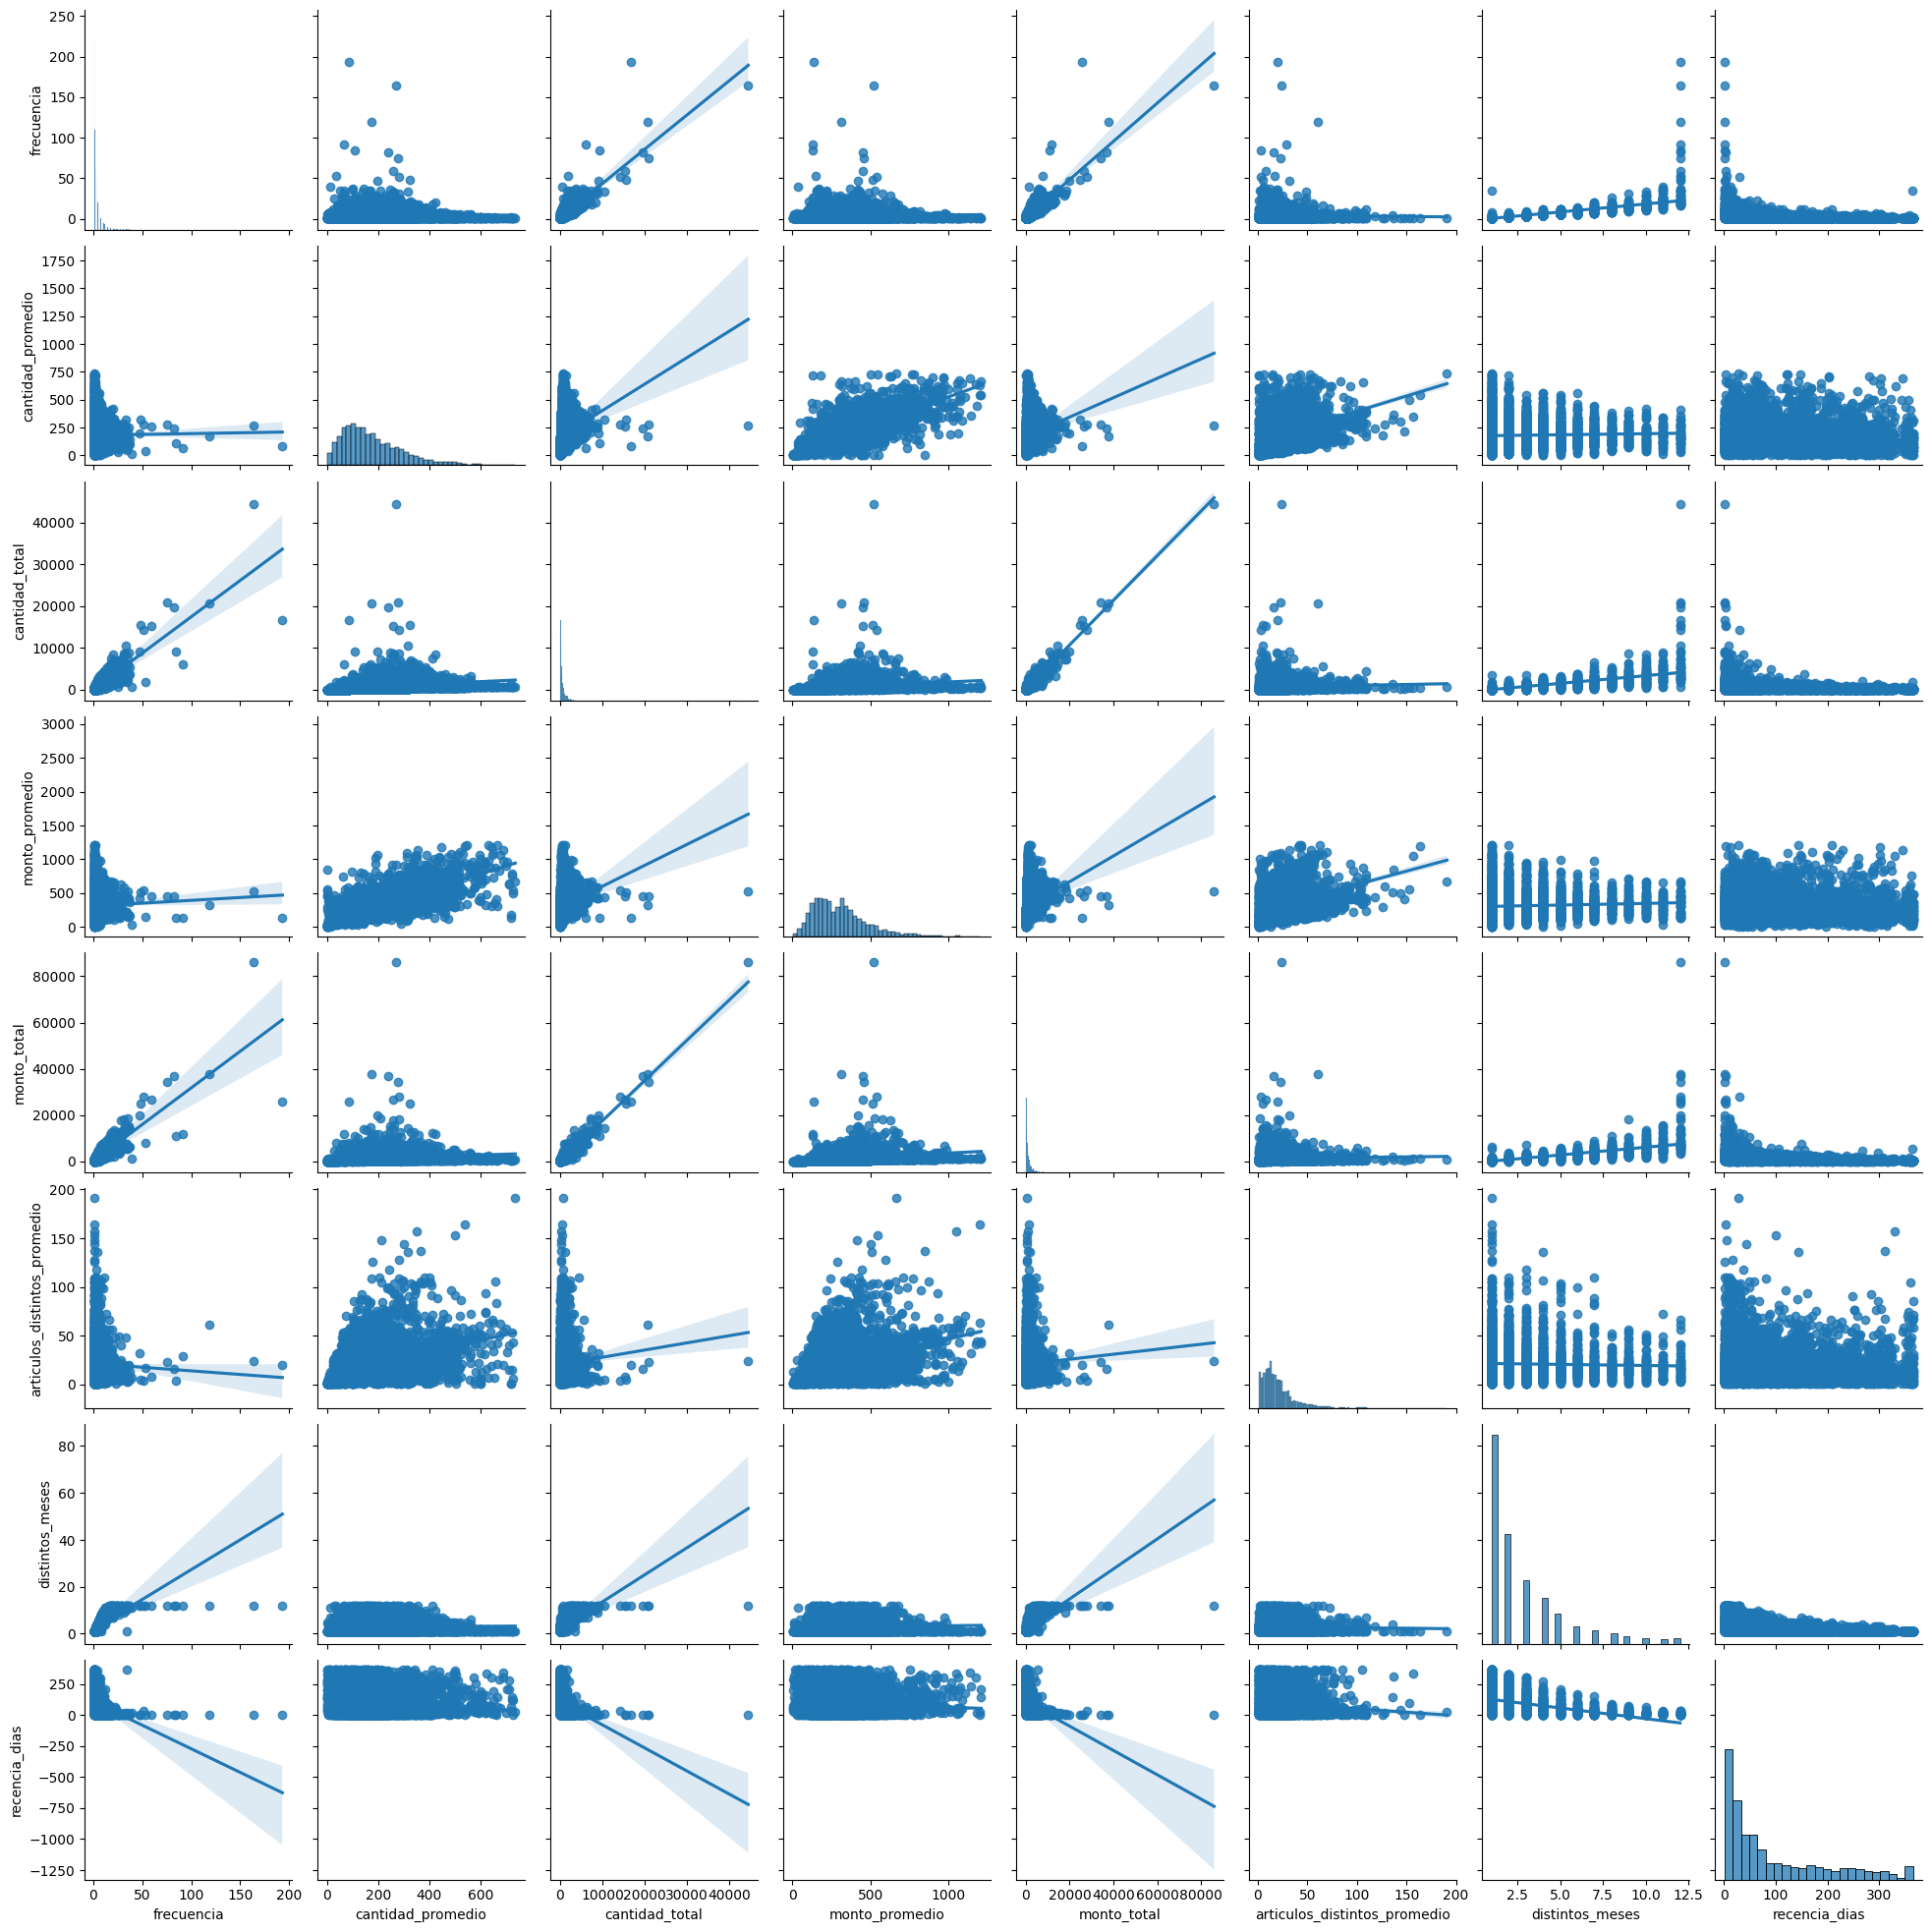

In [ ]:
sns.pairplot(data_seg, kind='reg')

Text(0.5, 1.0, 'Correlaciones')

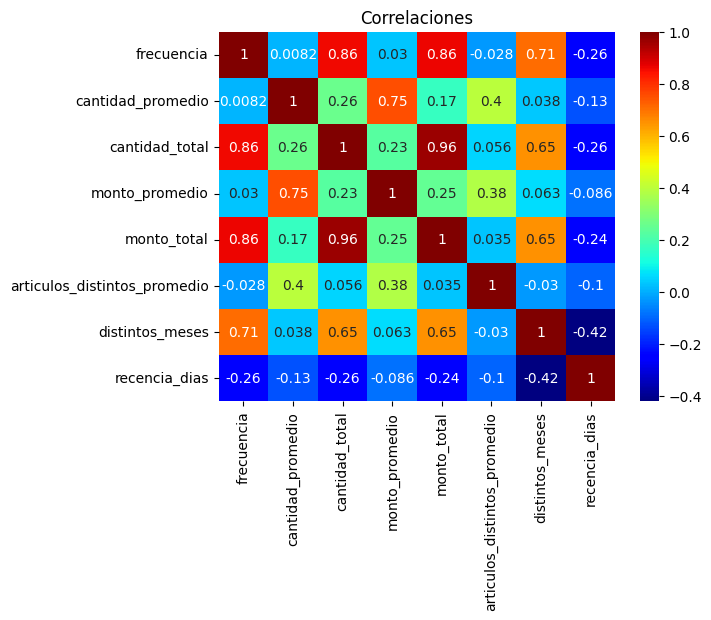

In [ ]:
sns.heatmap(data_seg.corr(), cmap='jet', annot=True)
plt.title('Correlaciones')

In [ ]:
X = data_seg.loc[:, ['frecuencia', 'monto_promedio', 'recencia_dias']].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
data_clus = pd.DataFrame(X_scaled, columns = ['var1', 'var2', 'var3'], index=X.index)
data_clus

,var1,var2,var3
CustomerID,,,
12347,0.156436,1.309476,0.279692
12348,-0.139765,-0.059698,-0.264114
12350,-0.435966,0.115895,2.102447
12352,0.600736,0.003109,-0.656862
12353,-0.435966,-1.193049,1.034977
...,...,...,...
18280,-0.435966,-0.704462,1.770121
18281,-0.435966,-1.236680,0.793286
18282,-0.435966,-1.133256,0.249480


- Clustering

- Metodo del codo

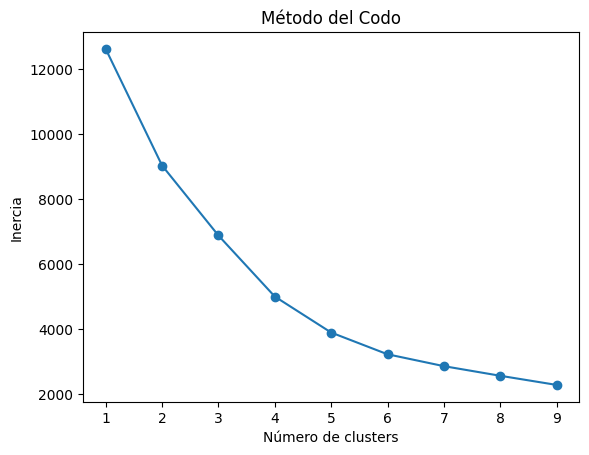

In [ ]:
inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_clus)
    inertia.append(kmeans.inertia_)


plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia')
plt.title('Método del Codo')
plt.show()

Se observa que 3 y 5 son buenos propectos para un numero de cluster óptimo

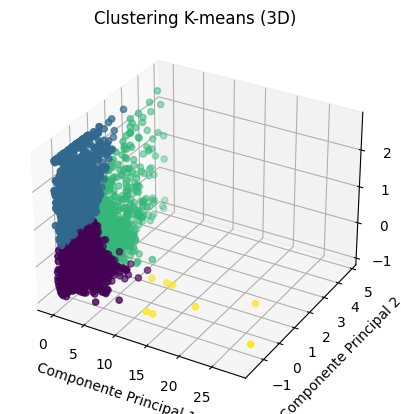

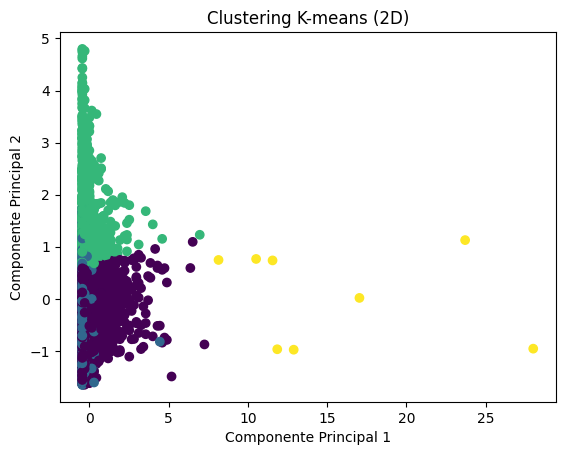

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(data_clus)

X['label_kmeans']= kmeans_labels

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], data_clus.iloc[:, 2], c=kmeans_labels)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Característica 3')
ax.set_title('Clustering K-means (3D)')
plt.show()


plt.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], c=kmeans_labels)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clustering K-means (2D)')
plt.show()

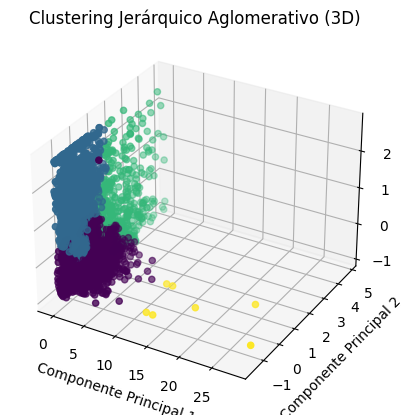

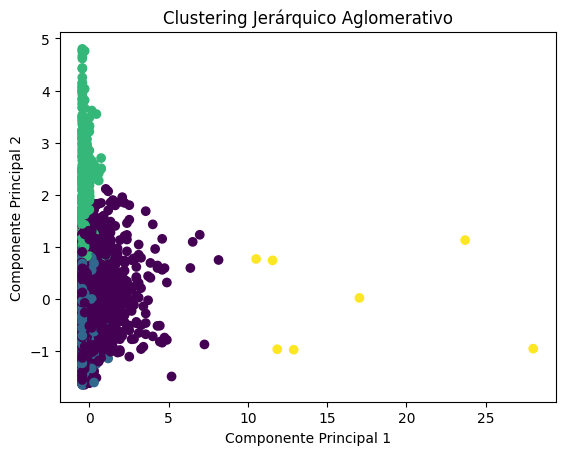

In [ ]:
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_labels = agg_clustering.fit_predict(data_clus)
X['label_agg']= agg_labels


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], data_clus.iloc[:, 2], c=agg_labels)
ax.set_xlabel('Componente Principal 1')
ax.set_ylabel('Componente Principal 2')
ax.set_zlabel('Característica 3')
ax.set_title('Clustering Jerárquico Aglomerativo (3D)')
plt.show()


plt.scatter(data_clus.iloc[:, 0], data_clus.iloc[:, 1], c=agg_labels)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Clustering Jerárquico Aglomerativo')
plt.show()

Calculamos la matriz de distancias y la de enlace para posteriormente generar dendrograma.

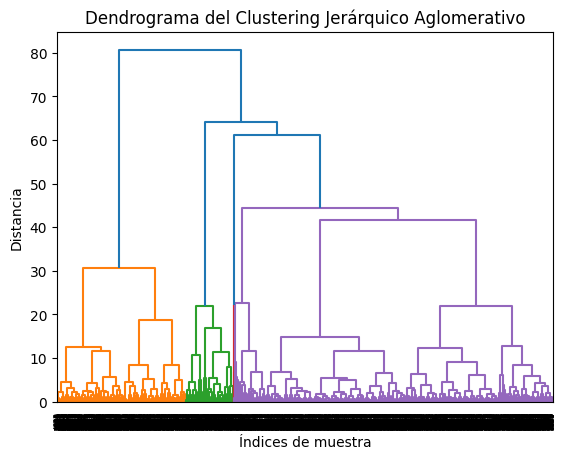

In [ ]:
distances = pdist(data_clus)
linkage_matrix = linkage(distances, method='ward')
dendrogram(linkage_matrix)

plt.xlabel('Índices de muestra')
plt.ylabel('Distancia')
plt.title('Dendrograma del Clustering Jerárquico Aglomerativo')
plt.show()

- Validación de Clusters

In [ ]:
for labels_i in [kmeans_labels, agg_labels]:
    db_index = davies_bouldin_score(data_clus, labels_i)
    silhouette_avg = silhouette_score(data_clus, labels_i)

    print(f"Índice de David-Bouldin: {db_index}")
    print(f"Coeficiente de Silhouette: {silhouette_avg}")
    print('*'*100)

Índice de David-Bouldin: 0.802571379231881
Coeficiente de Silhouette: 0.4064023466017712
****************************************************************************************************
Índice de David-Bouldin: 0.7745432833323656
Coeficiente de Silhouette: 0.38652279703298065
****************************************************************************************************


In [ ]:
resumen = X.reset_index().groupby('label_kmeans').agg({
    'CustomerID': 'count',
    'frecuencia' : ['mean', 'std'],
    'monto_promedio' : ['mean', 'std'],
    'recencia_dias' : ['mean', 'std'],
})

resumen.index = ['Compradores recurrentes', 'Compradores ocasionales - unicos', 'Compradores de montos altos', 'outliers']
resumen

CustomerID  frecuencia             \
                                      count        mean        std   
Compradores recurrentes                2401    4.688463   5.246148   
Compradores ocasionales - unicos       1010    1.595050   1.483098   
Compradores de montos altos             792    3.626263   4.203029   
outliers                                  8  108.375000  47.074220   

                                 monto_promedio             recencia_dias  \
                                           mean         std          mean   
Compradores recurrentes              249.663814   99.995656     38.137859   
Compradores ocasionales - unicos     228.875244  125.484804    243.037624   
Compradores de montos altos          610.430474  163.243131     70.106061   
outliers                             324.330934  169.694511      2.000000   

                                             
                                        std  
Compradores recurrentes           33.719686  
Compradores ocasionales - unicos  66.630994  
Compradores de montos altos       69.946766  
outliers                           0.755929